## Analyzing Bonus Certificates on the Telekom Stock

In the following notebook, we investigate Bonus Certificates linked to the Telekom stock. A Bonus Certificate is a type of structured derivative that offers investors conditional protection against moderate price declines, while still allowing participation in positive performance. We assume that any fraction of the security is tradable and that the risk-free interest rate $r$ is constant at 2% per annum. Our analysis focuses on understanding the product’s payoff structure, modeling its fair price under the Black-Scholes framework, and confirming the analytical price through a Monte Carlo simulation.

Contributors:
- Ivan von Greiff
- Lapo Mazzari
- Billy Hermann
- Kristi Nita
- Fabian Klemm

In [3]:
r = .02

The necessary Python libraries for numerical computations, data visualization, and financial modeling are imported first.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import skew, kurtosis

## Task 1

We begin by loading the historical closing prices of Telekom stock from the dataset `Telekom.csv`. The data spans **10 years**, from **June 17, 2014** to **June 16, 2024**. After parsing the dates and setting them as the index, we visualize the stock price evolution over time.



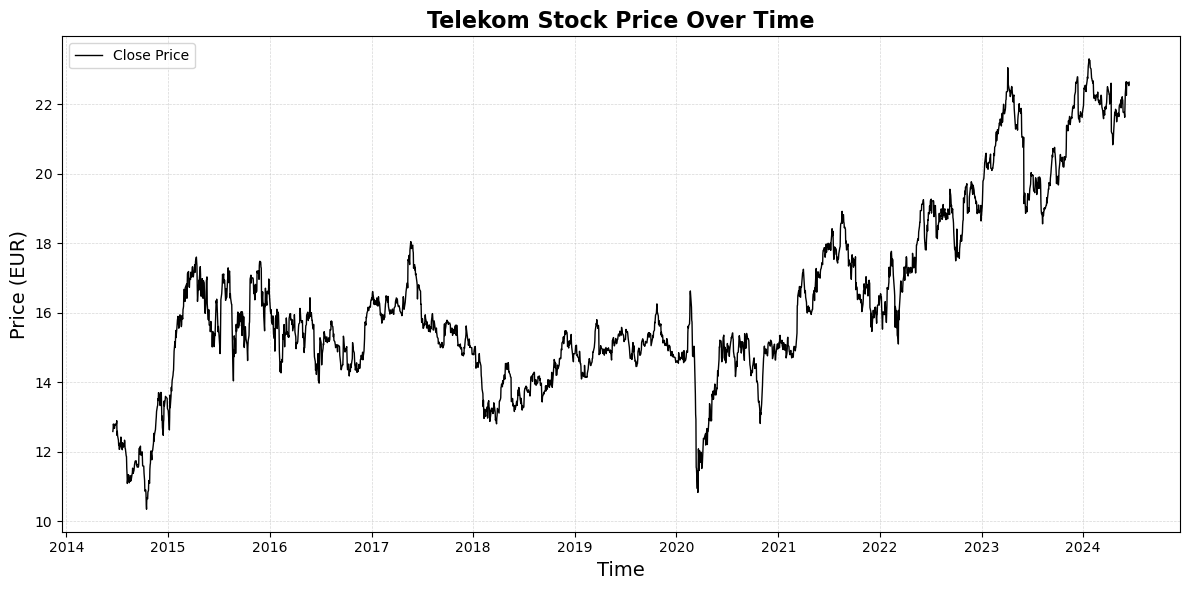

In [5]:
df = pd.read_csv("Telekom.csv", sep=',', index_col='Date'
)

df.index = pd.to_datetime(df.index)

plt.figure(figsize=(12, 6))

plt.plot(df['Close'], color='black', linewidth=1, label='Close Price')

plt.title('Telekom Stock Price Over Time', fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Price (EUR)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=.5, alpha=.5)
plt.legend()
plt.tight_layout()

plt.show()

Next, we compute the **log-returns** of the Telekom stock based on the daily closing prices. The log-return at time step $i$ is defined as
$$Y_i = \log\left(\frac{P_i}{P_{i-1}}\right).$$

Log-returns are widely used in financial modeling because of their desirable properties — notably, time additivity, and the fact that they tend to be approximately normally distributed over short intervals.

Again, we visualize their evolution over the full 10-year period to gain some insight into the volatility and the dynamic of the asset.

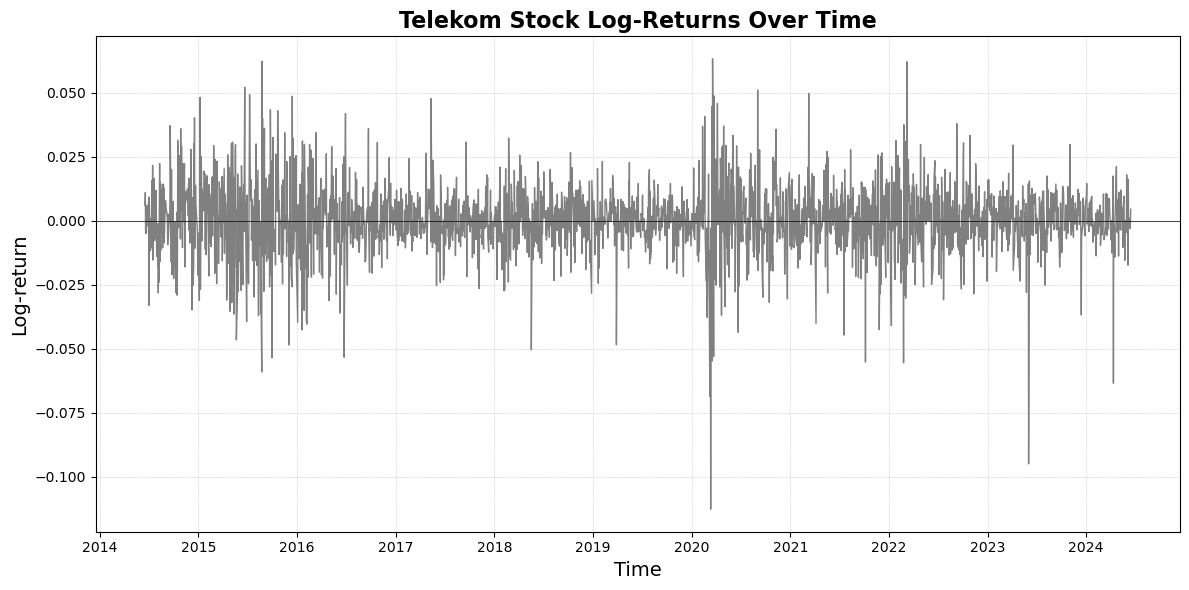

In [6]:
df = df.copy()

# Make sure 'Close' is numeric
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

closing_prices = df['Close']

log_returns = np.log(closing_prices / closing_prices.shift(1)).dropna()

df['Log_Returns'] = log_returns

plt.figure(figsize=(12,6))

plt.plot(log_returns, color='grey', linewidth=1)

plt.title('Telekom Stock Log-Returns Over Time', fontsize=16, weight='bold')
plt.xlabel('Time', fontsize=14)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.ylabel('Log-return', fontsize=14)
plt.grid(True, linestyle='--', linewidth=.5, alpha=.5)
plt.tight_layout()

plt.show()


To capture the key statistical features of the log returns, we report standard summary metrics such as the mean, standard deviation, minimum, maximum, and selected quantiles.

In [7]:
mean = log_returns.mean()
var = log_returns.var()
std = log_returns.std()
min_return = log_returns.min() 
max_return = log_returns.max()
q1 = log_returns.quantile(0.25) 
q2 = log_returns.quantile(0.50)  
q3 = log_returns.quantile(0.75)  

summary_stats = pd.DataFrame({
    "Statistic": ["Mean", "Variance", "Standard Deviation", "Minimum", "Maximum",
    "First Quartile (Q1)", "Median (Q2)", "Third Quartile (Q3)"],
    "Value": [mean, var,  std, min_return, max_return, q1, q2, q3]
})

# Descriptive statistics
stats_close = df[['Close']].describe().T
print(stats_close)

stats_logs = log_returns.describe().T
print(stats_logs)

df.head(-1)

        count       mean      std    min     25%    50%    75%        max
Close  2541.0  16.282396  2.59177  10.35  14.766  15.64  17.48  23.299999
count    2540.000000
mean        0.000231
std         0.013379
min        -0.112673
25%        -0.005909
50%         0.000000
75%         0.007092
max         0.063141
Name: Close, dtype: float64


,Close,Log_Returns
Date,,
2014-06-17,12.585000,NaN
2014-06-18,12.660000,0.005942
2014-06-19,12.800000,0.010998
2014-06-20,12.735000,-0.005091
2014-06-23,12.675000,-0.004723
...,...,...
2024-06-07,22.590000,-0.001769
2024-06-10,22.610001,0.000885
2024-06-11,22.610001,0.000000


## Task 2

In this section, we aim to fit the classical Black-Scholes model to the historical price data of the Telekom stock. This involves estimating the model's core parameters, namely the drift and volatility by using the empirical log-returns derived from the time series. We assume that prices follow a **geometric Brownian motion**, given by the stochastic differential equation:

$$
dB_t = rB_{t}dt \\
dP_t = \mu P_t \, dt + \sigma P_t \, dW_t
$$

where $B_t$ and $P_t$ are the risk free bank account and the stock price at time $t$, $\mu$ is the drift (constant), $\sigma$ is the volatility (constant) and $W_t$ is a standard Brownian motion. Let $Y_i$ denote the $i$‑th log‐return and $\widehat{Y}$ its sample mean.  By Itô’s lemma, the log‐price under the Black–Scholes model satisfies the SDE  
$$
d\ln P_t = \Bigl(\mu - \tfrac12\sigma^2\Bigr)\,dt + \sigma\,dW_t.
$$  
Discretizing over a time step $\Delta$ = $t_{i+1} - t_{i}$ gives i.i.d. log‐returns  
$$
Y_{i+1}
= \ln P_{t_{i+1}} - \ln P_{t_i}
\;\sim\;\mathcal{N}\!\bigl((\mu - \tfrac12\sigma^2)\,\Delta,\;\sigma^2\,\Delta\bigr).
$$  
Choosing a daily time‐step $\Delta = \tfrac1{252}$ (assuming 252 trading days per year), we obtain the estimators  
$$
\hat\sigma 
= \sqrt{\frac{\widehat{\mathrm{Var}}(Y)}{\Delta}},
\qquad
\hat\mu 
= \frac{\widehat{Y}}{\Delta} + \tfrac12\,\hat\sigma^2,
$$  
both of which carry annual units thanks to our choice of $\Delta$. In order to simulate the price path, we define the per‐step parameters as
$$
\mu_{\Delta}  = (\hat\mu - \tfrac12\,\hat\sigma^2)\,\Delta,
\qquad
\sigma_{\Delta} = \hat\sigma\,\sqrt{\Delta},
$$  
and simulate each daily increment via  
$$
\Delta\ln P = \mu_{\Delta} + \sigma_{\Delta}\,Z,
\quad Z\sim\mathcal{N}(0,1),
$$  
which yields the familiar discrete‐time update  
$$
P_{t+\Delta}
= P_t \exp\bigl(\mu_{\Delta} + \sigma_{\Delta}\,Z\bigr).
$$  

This exact discrete‐time scheme is fully consistent with the continuous‐time Black–Scholes SDE.  In a Monte Carlo setting, we generate $M$ independent paths of length $T/\Delta=252$, each reflecting one possible stock evolution.  As $M\to\infty$, the diffusion noise averages out and the sample mean path converges to the deterministic drift trend driven by $\hat\mu$.

The following plots illustrate the effect of increasing $M$ on the simulated average price paths, using $P_0$ = 12.59€, demonstrating convergence toward the expected price trajectory as the sample size grows.


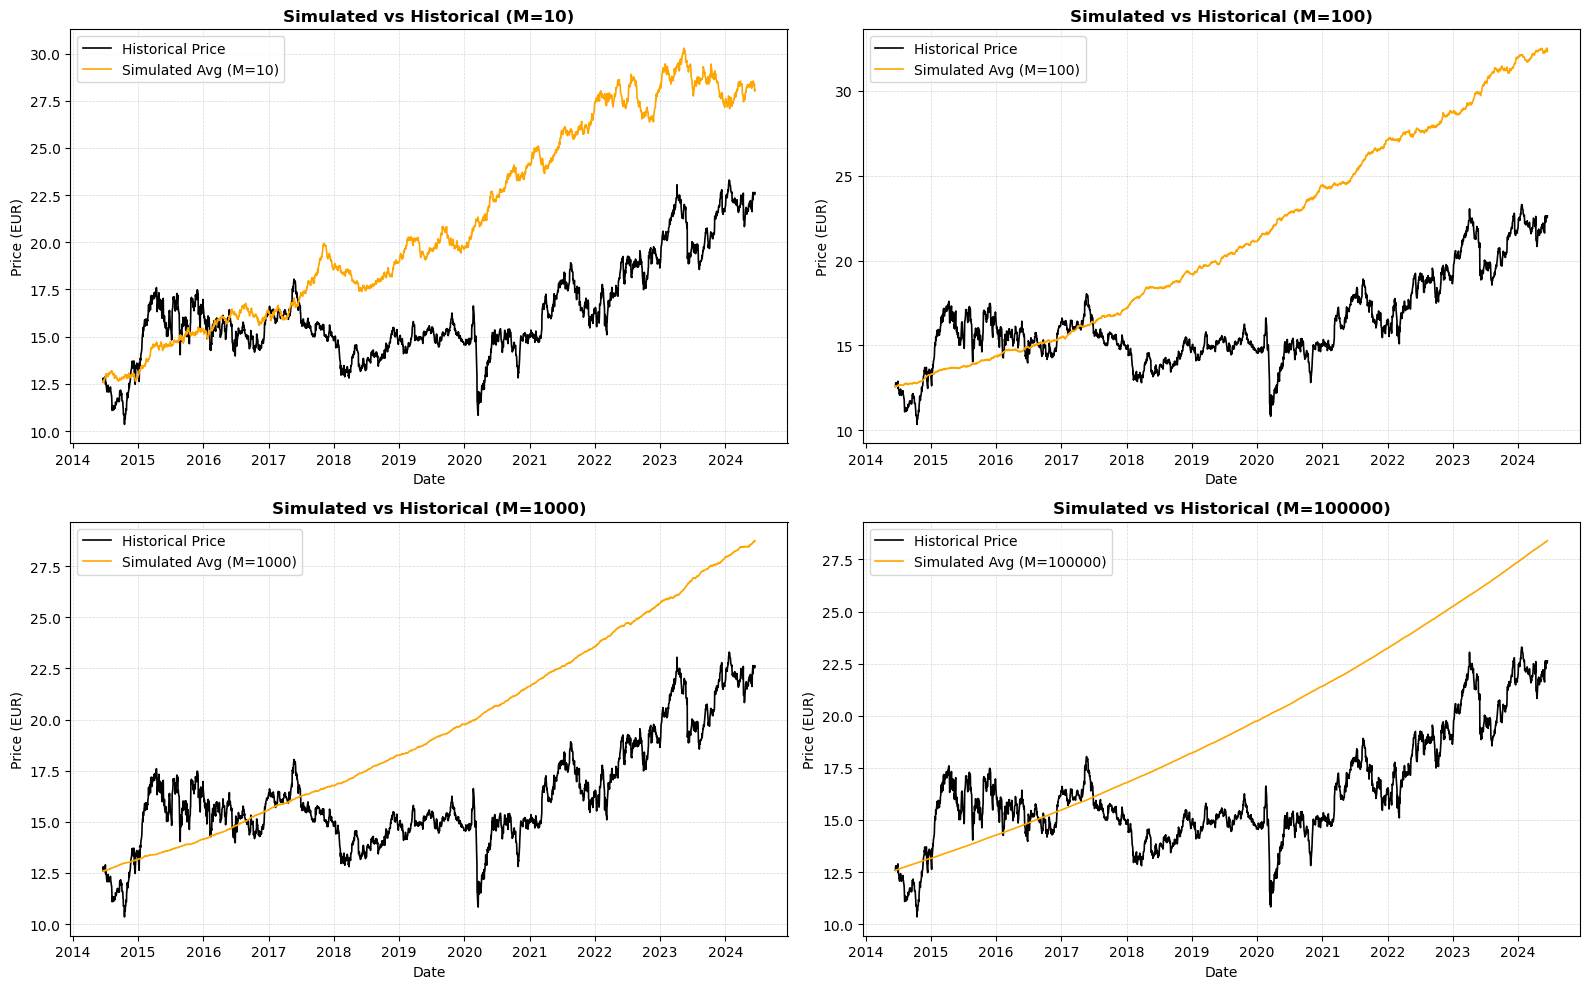

Annual Drift: 0.08077039134513142
Annual Volatility: 0.21239273290659064


In [ ]:
# Initial settings
P0 = df['Close'].iloc[0]   # historischer Startpreis
N = len(log_returns)          # Anzahl Tage im Datensatz

# 1. Annualisieren der täglichen Schätzer
trading_days  = 252
Delta         = 1 / trading_days   # ein Handelstag in Jahres­einheiten

sigma_annual   = std / np.sqrt(Delta)             
drift_annual      = mean / Delta + .5 * sigma_annual**2    

sigma = sigma_annual * np.sqrt(Delta)                    # vol_per_step
drift = (drift_annual - 0.5 * sigma_annual**2) * Delta      # drift_per_step

# Simulations with increasing number of paths
M_values = [10, 100, 1000, 100000]
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

for i, M in enumerate(M_values):
    # Generate all Brownian increments at once
    Z = np.random.normal(size=(M, N))

    # Simulated log‐price increments per day
    dlogP = drift + sigma * Z              # shape (M, N)

    # Build up log‐price paths
    log_price_paths = np.cumsum(dlogP, axis=1)
    log_price_paths = np.hstack([
        np.zeros((M, 1)),                   # log(P0) = 0 at t=0
        log_price_paths                     # cumulative increments
    ])  # shape (M, N+1)

    # Convert back to price
    price_paths = P0 * np.exp(log_price_paths)

    # Compute average trajectory
    average_path = price_paths.mean(axis=0)

    # Plot
    axs[i].plot(df.index, df['Close'], color='black', linewidth=1.2, 
                label='Historical Price')
    axs[i].plot(df.index, average_path, color='orange', linewidth=1.2, 
                label=f'Simulated Avg (M={M})')
    axs[i].set_title(f'Simulated vs Historical (M={M})', fontsize=12, 
                     fontweight='bold')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Price (EUR)')
    axs[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    axs[i].legend()

plt.tight_layout()
plt.show()

print(f"Annual Drift: {drift_annual}")
print(f"Annual Volatility: {sigma_annual }")


By averaging over all simulated paths, the randomness contributed by the diffusion term smoothes out, allowing the underlying drift component of the Black-Scholes model to become clearly visible. This demonstrates how the expected trend drives the price evolution when stochastic fluctuations are averaged out.

## Task 3

Bonus Certificates are structured financial products that provide investors with the opportunity for enhanced returns compared to directly holding the underlying asset, usually a stock. These products blend characteristics of traditional investments and options, offering a minimum guaranteed payout (the bonus level) as long as the underlying asset’s price does not fall below a predefined barrier level during the certificate’s lifetime.

In the following, we consider the payoff profile of a Bonus Certificate as an illustrative example. We assume a barrier level $H = 15$ and a bonus level $B=25$. The underlying asset price at maturity $P_T$ is varied between 0 and 40 to visualize the corresponding payoff of the certificate. This visualization highlights how the payoff behaves when the barrier is not breached during the lifetime of the derivative and shows the position of the terminal price relative to the bonus level.

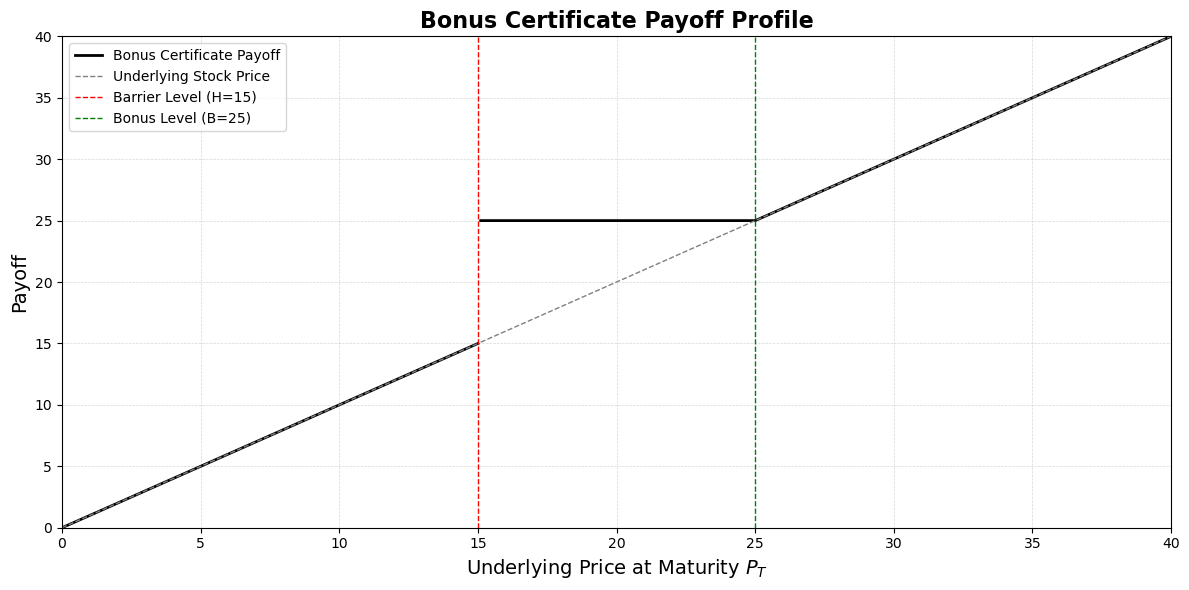

In [ ]:
H = 15 # Barrier
B = 25 # Bonus level

PT1 = np.linspace(0, 15, 500)
PT2 = np.linspace(15.1, 40, 500)

payoff1 = np.where(PT1 <= H, PT1, np.where(PT1 <= B, B, PT1))
payoff2 = np.where(PT2 <= H, PT2, np.where(PT2 <= B, B, PT2))

plt.figure(figsize=(12, 6))

plt.plot(PT1, payoff1, label='Bonus Certificate Payoff', color='black', 
         linewidth=2)
plt.plot(PT2, payoff2, color='black', linewidth=2)
plt.plot(PT1, PT1, label='Underlying Stock Price', color='gray', 
         linestyle='--', linewidth=1)
plt.plot(PT2, PT2, color='gray', linestyle='--', linewidth=1)

plt.axvline(H, color='red', linestyle='--', linewidth=1, 
            label=f'Barrier Level (H={H})')
plt.axvline(B, color='green', linestyle='--', linewidth=1, 
            label=f'Bonus Level (B={B})')
plt.title('Bonus Certificate Payoff Profile', fontsize=16, 
          weight = 'bold')
plt.xlabel('Underlying Price at Maturity $P_T$', fontsize=14)
plt.ylabel('Payoff', fontsize=14)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=.5, alpha=.5)
plt.tight_layout()
plt.show()


Investors may be drawn to Bonus Certificates because they offer the potential for higher returns compared to directly holding the underlying asset - especially when the stock price stays between the barrier and the bonus level. These instruments provide conditional downside protection: As long as the barrier is not breached, the investor is protected against moderate losses. In addition, if the underlying remains above the barrier at maturity, the investor receives a fixed bonus payout, which can exceed the return from simply holding the asset. This structure combines elements of capital preservation with the opportunity for enhanced yield in sideways or moderately bullish markets.



However, the main risk lies in the (possible) high volatility of the underlying asset’s price. Due to significant price fluctuations, there is an increased probability that the price will fall below the safety threshold at some point during the term. If the barrier is breached, the bonus mechanism expires, and the investor loses the protection, facing the full downside risk of the underlying.

This barrier risk is a key concern, as it can significantly affect the certificate’s payoff. Additionally, because Bonus Certificates are structured and more complex financial products, there are potential liquidity risks - it may be harder to sell them quickly or at a fair price compared to more straightforward investments.

In summary, while Bonus Certificates can be appealing for enhanced returns with partial protection, investors must carefully consider the volatility-driven barrier risk and the complexities that might affect liquidity.

## Task 4

As stated before, the payoff of a Bonus Certificate depends on the price of the corresponding underlying at Maturity $T$ **and** on whether the barrier $H$ was breached at any time during its lifetime. More precisely, given a predetermined Bonus Level $B$, the payoff of the Bonus Certificate equals B if and only if the barrier $H$ was not touched or breached during the product's lifetime and the terminal price $P_T \leq B$. In all other cases the payoff will simply be the terminal price $P_T$ itsself. We can formalize this by expressing the payoff $D$ as
$$D = B \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:,\: P_T \leq B\:\}} + P_T \cdot \mathbf{1}_{{\{\:\min_{t \in [0,T]} P_t > H\:,\: P_T \leq B\:\}}^c},$$ 
This says:
- If the barrier is _not_ breached AND terminal price $\le B$, you get $B$
- Else, you get $P_T$

This is equivalent to $$\begin{align*} D &= B \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:,\: P_T \leq B\:\}} + P_T - P_T \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:,\: P_T \leq B\:\}}\\
\Leftrightarrow D &= (B - P_T) \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:,\: P_T \leq B\:\}} + P_T \\
\Leftrightarrow D &= (B - P_T)^+ \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} + P_T
\end{align*}$$where $(B - P_T)^+ = \max\{B-P_T, 0 \}$. We can therefore replicate the payoff of the Bonus Certificate by a long on both, the Down-and-out put option with Strike $B$ and the underlying asset $P_t$. 

## Task 5

Our objective is now to find a fair value for the Bonus Certificate. Because the market model is complete, the price of any contingent claim coincides with the price of its replicating portfolio. We will use this fact along with risk-neutral pricing to price the Bonus Certificate.
$$
\begin{align*} V_0^D &= \mathbb{E}_{\mathbb{\tilde{Q}}}\left[e^{-r  T} D \right] = \mathbb{E}_{\mathbb{\tilde{Q}}}\left[e^{-r \cdot T} (B - P_T)^+ \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} + e^{-rT}P_T\right]\\
&= \mathbb{E}_{\mathbb{\tilde{Q}}} \left[e^{-r \cdot T} (B - P_T)^+ \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} \right] + \mathbb{E}_{\mathbb{\tilde{Q}}} \left[e^{-rT} P_T \right]\\
&= \mathbb{E}_{\mathbb{\tilde{Q}}} \left[e^{-r \cdot T} (B - P_T)^+ \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} \right] + P_0.
\end{align*}$$
Now, since $$ (B-P_T)^+ = (P_T - B)^+ - (P_T - B)$$ we further obtain that
$$
\begin{align*} V_0^D &= \mathbb{E}_{\mathbb{\tilde{Q}}} \left[e^{-r \cdot T} \left((P_T - B)^+ - (P_T - B)\right) \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} \right] + P_0 \\
&= \mathbb{E}_{\mathbb{\tilde{Q}}} \left[e^{-r \cdot T} (P_T - B)^+ \cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} \right] - \mathbb{E}_{\mathbb{\tilde{Q}}} \left[e^{-r \cdot T} (P_T - B)\cdot \mathbf{1}_{\{\:\min_{t \in [0,T]} P_t > H\:\}} \right] + P_0\\
&= DOC(P_0,0) + e^{-rT} B Q^{(2)} - P_0(Q^{(1)}-1) \\
&= C(P_0,0) - KOD(P_0,0) + e^{-rT} B Q^{(2)} - P_0(Q^{(1)}-1),
\end{align*}$$
where $C(P_0,0)$ denotes the vanilla call option price at $t=0$, $KOD(P_0,0)$ the knockout discount, by which the knockout barrier $H$ lowers the price and $Q^{(1,2)}$ as given on the task sheet. Note that we make use of the formulas for a Down-and-out call derived in our lecture.

We now explicitely compute the price of a Bonus Certificate on the Telekom stock with $P_0$ equal to the price quoted on 14.06.2024, barrier level 16, bonus level 24 and maturity of 1 year. We will use the market parameters from above and since we are valuating with respect to the risk-neutral measure, we will use the risk-free rate $r$ as drift. 

In [10]:
P0 = df.at['14-06-2024', 'Close']
H = 16 # barrier
B = 24 # bonus
T = 1 # Maturity
print(P0)

22.6299991607666


In [ ]:
def Call(P0, r, sigma, T, K):
    a = np.log(P0 / K) + (r + .5 * sigma**2) * T
    c = sigma * np.sqrt(T)
    d1 = a / c
    d2 = d1 - c
    call_price = P0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def KOD(P0, r, sigma, T, K, H):
    lam = (r - .5 * sigma**2)
    x1 = (np.log(H**2 / (P0 * K)) 
          + (r + .5 * sigma**2) * T) / (sigma * np.sqrt(T))
    x2 = x1 - sigma * np.sqrt(T)

    term1 = P0 * (H / P0) ** (2 + 2 * lam / sigma**2) * norm.cdf(x1)
    term2 = K * np.exp(-r * T) * (H / P0) ** (2 * lam / sigma**2) * norm.cdf(x2)
    
    return term1 - term2

def DOC(P0, r, sigma, T, K, H):
    vanilla_call = Call(P0, r, sigma, T, K)
    knock_out_discount = KOD(P0, r, sigma, T, K, H)
    return vanilla_call - knock_out_discount

def option_price(P0, r, sigma, T, B, H):
    d1 = (np.log(P0/H) + (r + .5 * sigma**2) * T) / (sigma * np.sqrt(T))
    q1 = norm.cdf(d1) 
    - np.exp(-(2*(r + .5 * sigma**2) * np.log(P0/H))/ sigma**2) * norm.cdf(
        (-np.log(P0/H) + (r + .5 * sigma**2) * T)/sigma*np.sqrt(T)
    )
    d2 = d1 - sigma * np.sqrt(T)
    q2 = norm.cdf(d2) 
    - np.exp(-(2*(r - .5 * sigma**2)*np.log(P0/H))/sigma**2) * norm.cdf(
        (-np.log(P0/H) + (r - .5 * sigma**2) * T)/sigma*np.sqrt(T)
    )
    price = DOC(P0, r, sigma, T, B, H) + np.exp(-r * T) * B * q2 - P0*(q1 - 1)
    return price

analytical_price = option_price(P0, r, sigma_annual, T, B, H)
print(f"Historical P_0 (underlying): {P0}")
print(f"Estimated Fair Bonus Certificate Price: {analytical_price}")

Historical P_0 (underlying): 22.6299991607666
Estimated Fair Bonus Certificate Price: 24.250958693982824


## Task 6

To confirm the pricing formula derived analytically in Task 5, we use a Monte Carlo simulation approach. The idea is to simulate multiple price paths of the underlying asset under the risk-neutral measure and evaluate the expected discounted payoff of the Bonus Certificate. Therefore, this time, we simulate **price paths** using the interest rate $r=0.02$ as a drift to approximate the option price numerically.

We simulate 100,000 price paths of the underlying asset over a one-year horizon using the geometric Brownian motion model. At each timestep, we monitor whether the barrier $H$ has been breached.

To achieve computational efficiency, we employ vectorized NumPy operations to:

1. Simulate all Brownian increments simultaneously.

2. Track barrier breaches for each path.

3. Calculate final *discounted* payoffs accordingly.

Additionally, we use antithetic variables to reduce the variance of our Monte Carlo estimator, improving the accuracy and convergence speed of the price estimate without increasing the number of simulations.

The price of the Bonus Certificate is then estimated as the average discounted payoff across all simulated paths. This approach allows us to approximate the fair value of the product under the risk-neutral measure efficiently and with high numerical stability.

In [ ]:
def simulate_paths_with_barrier_antithetic(P0, drift, sigma, T, steps, H, M):
    dt = T / steps
    Z = np.random.normal(size=(M, steps))
    Z_antithetic = -Z

    def simulate(Z):
        increments = (drift - .5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        log_P = np.cumsum(increments, axis=1)
        log_P = np.hstack([np.full((M, 1), np.log(P0)), np.log(P0) + log_P])
        P = np.exp(log_P)
        breached = (P <= H).any(axis=1)
        PT = P[:, -1]
        return breached, PT

    breached1, PT1 = simulate(Z)
    breached2, PT2 = simulate(Z_antithetic)

    breached = np.concatenate([breached1, breached2])
    PT = np.concatenate([PT1, PT2])

    return breached, PT

def monte_carlo_vectorized_antithetic(P0, drift, sigma, T, steps, H, B, r, 
                                      M=10000):
    # Half the number of random paths, but each one gives 2 results
    breached, PT = simulate_paths_with_barrier_antithetic(P0, drift, sigma, 
                                                          T, steps, H, M)

    # Compute payoff for each path
    put_payoff = np.maximum(B - PT, 0)
    payoffs = np.where(breached, PT, PT + put_payoff)
    
    # Discount the payoff of each path back to present using risk-free rate r 
    # (pricing is under risk-neutral measure)
    discounted_payoffs = np.exp(-r * T) * payoffs

    return discounted_payoffs.mean()

monte_carlo_price = monte_carlo_vectorized_antithetic(P0, r, sigma_annual, 
                                                      T, 10000, H, B, r)

print(monte_carlo_price)

24.2646604645371


To validate the analytical pricing formula, we compared it to the result obtained via Monte Carlo simulation. The absolute error and relative error between the two methods were calculated as follows:

In [ ]:
def compare_prices(true_value, estimated_value, label="Price"):
    abs_error = abs(true_value - estimated_value)
    rel_error = abs_error / abs(true_value) * 100 if true_value != 0 else float('inf')
    
    print(f"{label}:")
    print(f"  Analytical value  = {true_value:.6f}")
    print(f"  Monte Carlo value = {estimated_value:.6f}")
    print(f"  Absolute error    = {abs_error:.6f}")
    print(f"  Relative error    = {rel_error:.4f}%\n")

compare_prices(analytical_price, monte_carlo_price, label="Comparison of results")




Comparison of results:
  Analytical value  = 24.250959
  Monte Carlo value = 24.264660
  Absolute error    = 0.013702
  Relative error    = 0.0565%



The small error observed confirms that the Monte Carlo method provides a close numerical approximation to the theoretical price. Such small deviations are normal due to the randomness of simulations. The result supports the correctness of the analytical pricing formula derived earlier. If higher accuracy is needed, the simulation can be refined by increasing the number of simulated paths or applying variance reduction techniques.

##### Overestimating Barrier Options with Monte Carlo Simulation:  

When Calculating the Monte Carlo price multiple times one might notice, that it is always slightly higher then the analytical price. One might suggest that the Absolute error between the analytical and numerical price might not only be caused by the randomness of the simulation. In fact the Monte Carlo price is always slightly overestimating the price of the bonus certificate, as it only checks if the barrier was breached in discrete time steps. In theory a price could breach the barrier between two time steps but not be detected by the Monte Carlo Payoff simulation algorithm, leading to more bonus-paying simulations and in this way driving up the price of the option. Therefore increasing the number of steps in the path simulation, would decrease the bias, but on the other hand grow the computational effort significantly.

## Task 7

We now simulate the evolution of the underlying price and the payoff of the Bonus Certificate under the physical probability measure. This allows us to investigate the risk characteristics of the instrument and compare them directly with those of the underlying asset. Specifically, we compare the distributional properties of the terminal asset price $P_T$​ and the corresponding certificate payoff. For both variables, we compute key summary statistics: the mean, variance, skewness, kurtosis, and the 5% quantile (i.e., Value-at-Risk at 95% confidence level).

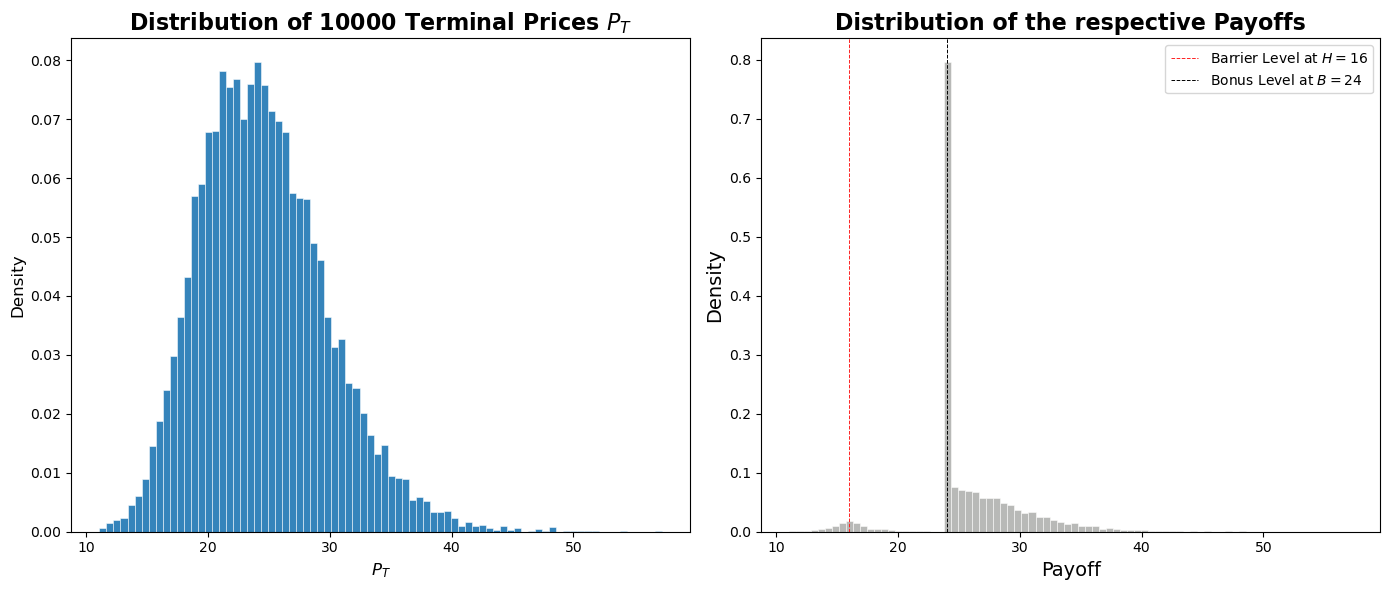

Terminal Prices Statistics:
--------------------------
Mean                : 24.5986
Variance            : 27.9429
Standard Deviation  : 5.2861
Skewness            : 0.6568
Excess Kurtosis     : 0.9544
Max                 : 57.2561
Min                 : 11.0952
5% Quantile (VaR)   : 16.9495

Payoffs Statistics:
------------------
Mean                : 25.9064
Variance            : 19.1188
Standard Deviation  : 4.3725
Skewness            : 0.6998
Excess Kurtosis     : 3.4457
Max                 : 57.2561
Min                 : 11.0952
5% Quantile (VaR)   : 17.9272



In [ ]:
def simulate_paths_physical(P0, drift, sigma, T, steps, H, B, M=10000):
    dt = T / steps

    # Simulate all Brownian motion increments at once
    Z = np.random.normal(size=(M, steps))
    increments = (drift - .5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z

    # Cumulative log-prices and prepend log(P0)
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack([np.full((M, 1), np.log(P0)), log_paths + np.log(P0)])

    # Convert to price paths
    P_paths = np.exp(log_paths)
    PT = P_paths[:, -1]  # Final price at maturity

    # Barrier check: was H ever breached?
    breached = (P_paths <= H).any(axis=1)

    # Payoffs
    put_payoff = np.maximum(B - PT, 0)
    payoffs = np.where(breached, PT, PT + put_payoff)

    return PT, payoffs, P_paths

M = 10000
PT, payoffs, P_paths= simulate_paths_physical(P0, drift_annual, sigma_annual, 
                                              1, 10000, 16, 24, M)

plt.figure(figsize=(14, 6))

# 1. Distribution of Terminal Prices P_T
plt.subplot(1, 2, 1)
plt.hist(PT, bins=80, color='#1f77b4', alpha=0.9, density=True, 
         edgecolor='white', linewidth=0.4)
plt.title(f'Distribution of {M} Terminal Prices $P_T$', fontsize=16, 
          weight='bold')
plt.xlabel('$P_T$', fontsize=12)
plt.ylabel('Density', fontsize=12)

# 2. Distribution of Payoffs
plt.subplot(1, 2, 2)
plt.hist(payoffs, bins=80, color="#B1B2AF", alpha=0.9, density=True, 
         edgecolor='white', linewidth=0.4)
plt.title('Distribution of the respective Payoffs', fontsize=16, 
          weight='bold')
plt.xlabel('Payoff', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.ylabel('Density (log-scale)', fontsize=14)
plt.axvline(x=16, color="#FD2222", linestyle='--', linewidth=.7, 
            label='Barrier Level at $H=16$')
plt.axvline(x=24, color="#000000", linestyle='--', linewidth=.7, 
            label='Bonus Level at $B=24$')
ax = plt.gca()
# place little triangle markers at y=0 in *axes coordinates*
# ax.scatter([H, B], 
#            [0, 0], 
#            marker='', 
#            s=100, 
#            color=['#FD2222','#000000'], 
#            transform=ax.get_xaxis_transform(),  # (x in data, y in axes coords)
#            clip_on=False)
#plt.yscale('log') better to show it like this?
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

def print_stats(name, data):
    stats = {
        "Mean": np.mean(data),
        "Variance": np.var(data),
        "Standard Deviation": np.std(data),
        "Skewness": skew(data),
        "Excess Kurtosis": kurtosis(data),  # excess kurtosis (normal=0)
        "Max": np.max(data),
        "Min": np.min(data),
        "5% Quantile (VaR)": np.quantile(data, 0.05),
    }
    
    print(f"{name} Statistics:")
    print("-" * (len(name) + 11))
    for stat_name, value in stats.items():
        print(f"{stat_name:<20}: {value:.4f}")
    print()

print_stats("Terminal Prices", PT)
print_stats("Payoffs", payoffs)

The results of the simulation reveal distinct differences between the underlying asset and the payoff of the structured product. The distribution of the terminal asset price $P_T$ is more or less continuous and exhibits positive skewness, as expected from a geometric Brownian motion process. Its kurtosis is moderate, consistent with the thin tails of the log-normal distribution.

In contrast, the distribution of the certificate's payoff is more irregular. Due to the non-linear nature of the payoff function (influenced by the barrier and bonus level), the distribution is discontinuous and clustered around key values. We observe a concentration of mass at the bonus level $B = 24$, reflecting scenarios in which the barrier was not breached and the investor received the bonus. The kurtosis of the payoff distribution is significantly higher, showing that the payoff is more asymmetric and more prone to extreme outcomes than the terminal price itself.

Notably, the Value-at-Risk of the payoff distribution is slightly higher than that of the underlying asset. This reflects the downside protection provided by the barrier feature of the Bonus Certificate, which cushions losses in adverse scenarios.

These differences highlight the value added by structured products in tailoring risk-return profiles, but they also underline the complexity in analyzing and pricing such instruments.

In [15]:
#One last thing we can do is plot 95% CI Cones for the simulated physical price paths:
lower_bound = np.percentile(P_paths, 5, axis=0)
median       = np.percentile(P_paths, 50, axis=0)
upper_bound = np.percentile(P_paths, 95, axis=0)

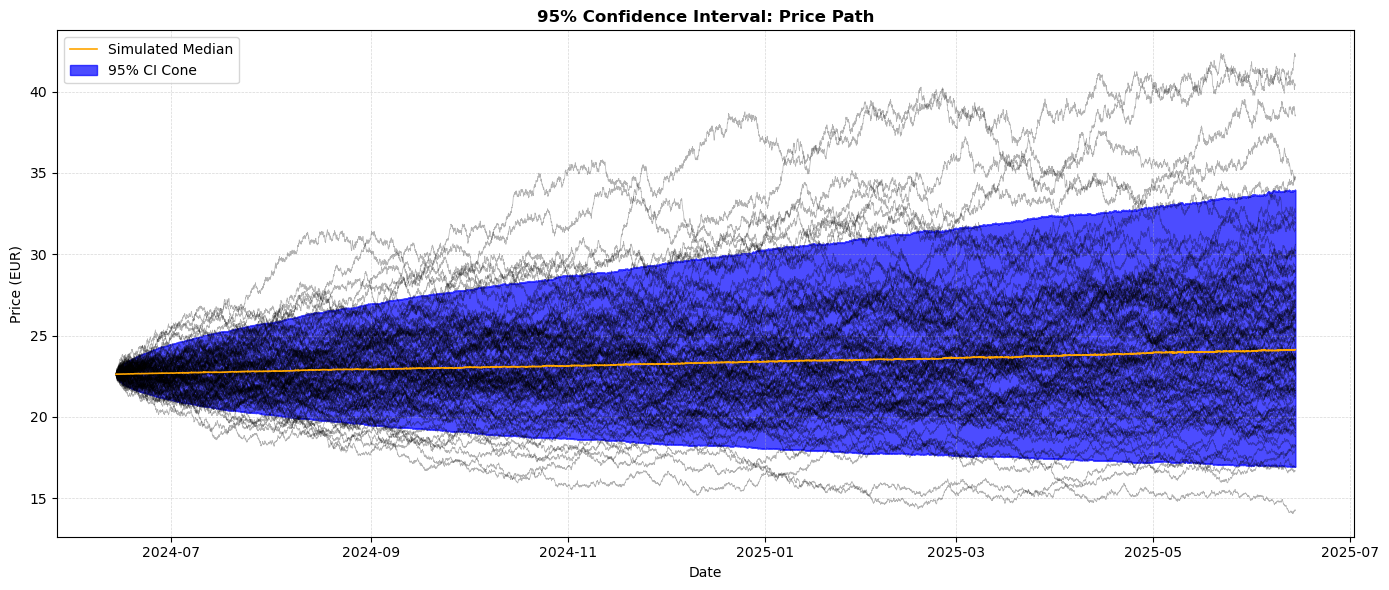

In [ ]:
# Step 1: Compute quantiles BEFORE plotting
lower_bound = np.percentile(P_paths, 5, axis=0)
median      = np.percentile(P_paths, 50, axis=0)
upper_bound = np.percentile(P_paths, 95, axis=0)

# Step 2: Define date range
start_date = df.index[-1]  # last historical date
end_date = start_date + pd.Timedelta(days=365)
sim_dates = pd.to_datetime(np.linspace(start_date.value, 
                                       end_date.value, P_paths.shape[1]))

# Step 3: Plot
plt.figure(figsize=(14, 6))

# Plot 100 random paths for context
for i in range(100):
    plt.plot(sim_dates, P_paths[i], color='black', linewidth=0.5, 
             alpha=0.3)

# Plot median line
plt.plot(sim_dates, median, color='orange', linewidth=1.2, 
         label='Simulated Median')

# Plot shaded 95% confidence cone
plt.fill_between(sim_dates, lower_bound, upper_bound, color='blue', 
                 alpha=0.7, label='95% CI Cone')

# Final plot settings
plt.title('95% Confidence Interval: Price Path', fontsize=12, 
          fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (EUR)')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()